In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.compose import TransformedTargetRegressor

from copy import copy

from regression_model import RegressionModel
from hyperparameter_optimizer import HyperParameterOptimizer
from diagnostics import HPODiagnoser, ModelDiagnoser
from interpret import ModelInterpreter
from preprocessor import FeaturePreprocessor

random_seed = 1001

In [2]:
#X, y = datasets.load_diabetes(return_X_y= True)
X, y = datasets.load_boston(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed, shuffle = True)


X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
print(X_train.shape, X_test.shape)

(404, 13) (102, 13)


In [3]:


model_name = "random_forest"

obj_func_name = "mse"
total_n_iterations = 200
eval_func_names = ["rmse", "r_squared"]
n_estimators = 400
train_valid_folds = 10
log_target_reg = False

In [4]:
# model fitting
base_model = RegressionModel(X_train = X_train, y_train = y_train, model_type = model_name, 
                        obj_func_name = obj_func_name, random_seed = random_seed,
                            log_target_reg = log_target_reg)


if model_name == "random_forest":
    model_params = {"n_estimators":n_estimators}
else:
    model_params = {}
base_model.fit(model_params = model_params)

In [5]:
# hyperparameter tuner
hpo = HyperParameterOptimizer(verbosity = 1)
if model_name == "random_forest":
    override_params = {"n_estimators":n_estimators}
else:
    override_params = {}
hpo.tune_and_fit(model = base_model,
                total_n_iterations = total_n_iterations,
                train_valid_folds = train_valid_folds,
                use_model_copy = True,
                override_params = override_params)
tuned_model = hpo.model

{'max_features': 0.7627403021361978, 'min_samples_leaf': 1, 'min_samples_split': 8, 'criterion': 'mse'}


C:\Users\joshua\Anaconda3\envs\grape\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


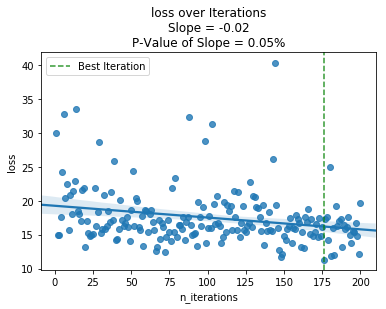

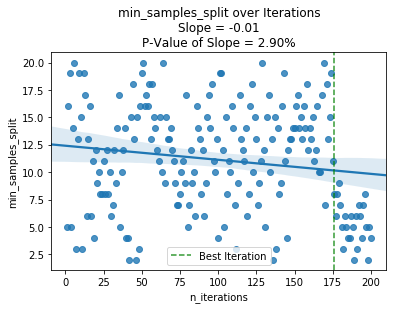

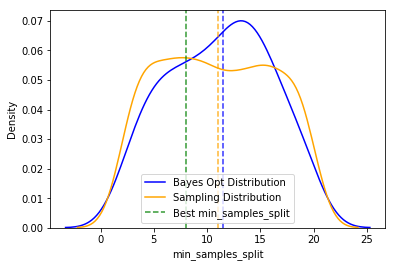

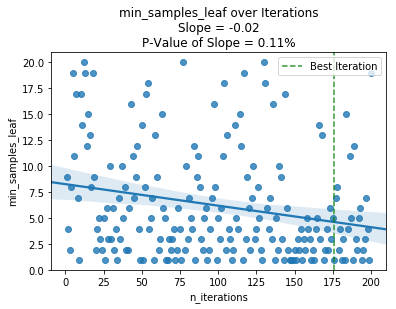

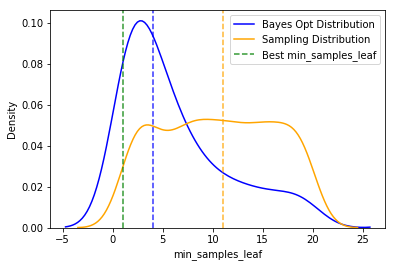

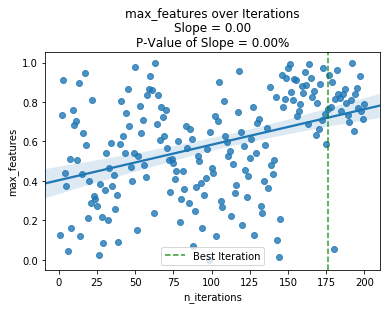

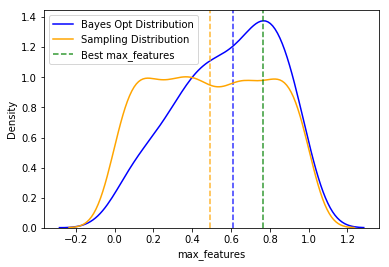

In [6]:
# diagnostics of hyperparameter tuner

hpo_diagnoser = HPODiagnoser(hpo)
figures = hpo_diagnoser.show_all_diagnostics()
plt.show()

In [7]:
# model interpretation
interpreter = ModelInterpreter(tuned_model)
interpreter.feature_importance_df

,feature_importance
5,0.449070
12,0.310622
7,0.060757
4,0.041558
0,0.041325
6,0.021638
10,0.021519
2,0.021414
9,0.014728
11,0.010618


Base Model
{'train-rmse': 1.2606546617558223, 'oob-rmse': 3.393055367903642, 'test-rmse': 3.7659371152483314, 'train-r_squared': 0.9800932116651193, 'oob-r_squared': 0.8557915119588386, 'test-r_squared': 0.8593203607689559, 'cv-rmse-mean': 3.396515419656802, 'cv-rmse-std': 0.7607959861535143, 'cv-r_squared-mean': 0.8401021976546765, 'cv-r_squared-std': 0.06648321804999024}


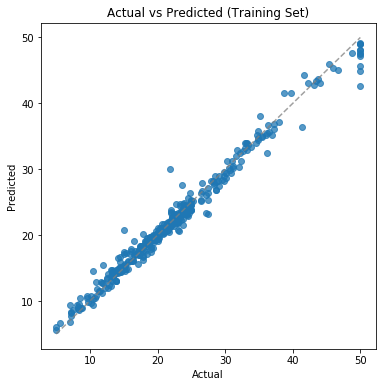

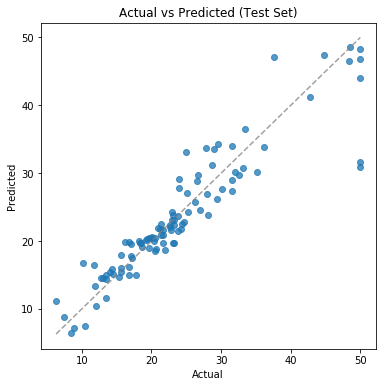

Tuned Model
{'train-rmse': 1.6624362018000325, 'oob-rmse': 3.3960424247742034, 'test-rmse': 3.6825531247713736, 'train-r_squared': 0.965382244536763, 'oob-r_squared': 0.855537493962455, 'test-r_squared': 0.8654811456781192, 'cv-rmse-mean': 3.3964599873636296, 'cv-rmse-std': 0.7183472179289985, 'cv-r_squared-mean': 0.8412136894729203, 'cv-r_squared-std': 0.06237172453502272}


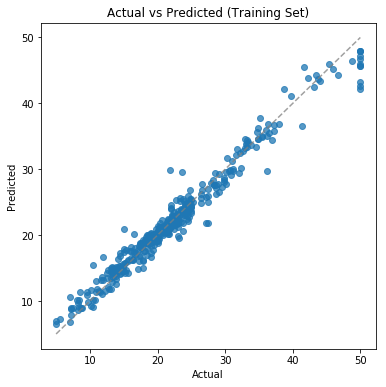

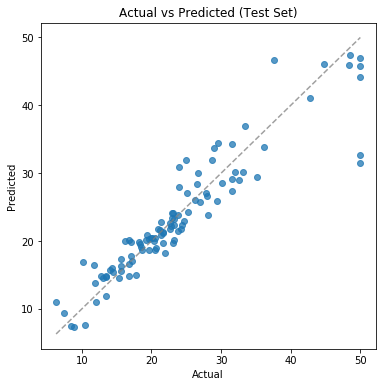

In [8]:
print("Base Model")
base_model_diagnoser = ModelDiagnoser(base_model, 
                                      train_valid_folds = train_valid_folds,
                                      eval_func_names = eval_func_names,
                                     X_test = X_test,
                                     y_test = y_test)
base_model_diagnoser.show_all_diagnostics()
plt.show()

print("Tuned Model")
tuned_model_diagnoser = ModelDiagnoser(tuned_model, 
                                       train_valid_folds = train_valid_folds,
                                      eval_func_names = eval_func_names,
                                      X_test = X_test,
                                      y_test = y_test)
tuned_model_diagnoser.show_all_diagnostics()
plt.show()